In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

## Load and explore data

In [2]:
df = pd.read_csv('cnsl_data.csv', index_col=0)

Check data for missing values

In [3]:
df.isna().sum().sum()

0

Split the data into 3 parts, cnsl data, control data and ethnicity of the subjects

In [4]:
cnsl_df = df.iloc[:,1:51]
ctrl_df = df.iloc[:,51:]
ethnicities = df.ethnicity

In [5]:
ethnicity_counts = ethnicities.value_counts()
ethnicity_counts

ethnicity
A    4988
B    2543
C    2469
Name: count, dtype: int64

The main idea behind my cnv calling method is that a given subject will have similar read depths on probes with similar efficacy. 

I'll use mean probe depths to estimate the efficacies of the probes and mean sample depths from the subjects in the control group to estimate sample depths in the cnsl group. 


In [6]:
ctrl_mean_probe_depth = ctrl_df.mean(axis=0) 
cnsl_mean_probe_depth = cnsl_df.mean()

ctrl_mean_sample_depth = ctrl_df.mean(axis=1)

Plot to visualize read depth range in the control group and how it changes with mean probe depth

Text(0, 0.5, 'probe depth')

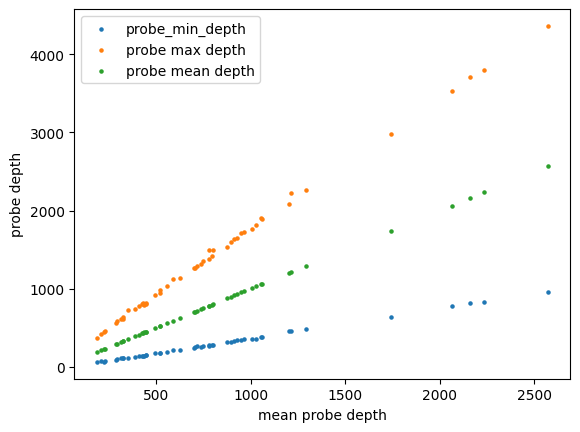

In [7]:

min_values = ctrl_df.min()  
max_values = ctrl_df.max()

plt.scatter(ctrl_mean_probe_depth, min_values, s=5, label='probe_min_depth')
plt.scatter(ctrl_mean_probe_depth, max_values, s=5, label='probe max depth')
plt.scatter(ctrl_mean_probe_depth, ctrl_mean_probe_depth, s=5, label='probe mean depth')
plt.legend()
plt.xlabel('mean probe depth')
plt.ylabel('probe depth')


Plot to compare the read depths of the first subject

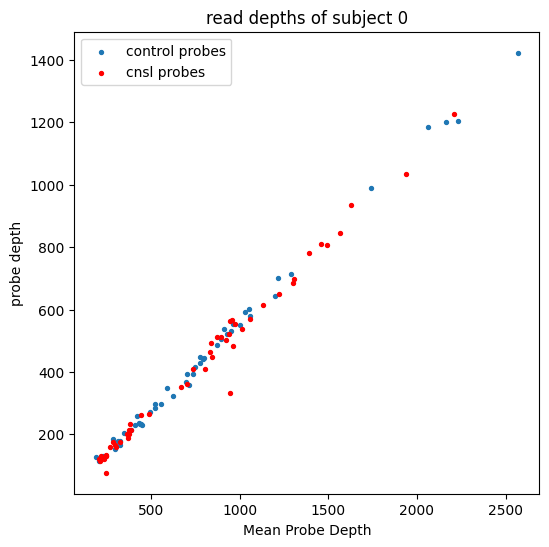

In [8]:
plt.figure(figsize=(6,6))
j = 0

plt.scatter(ctrl_mean_probe_depth, ctrl_df.iloc[j,:], s=8, label='control probes')
plt.scatter(cnsl_mean_probe_depth, cnsl_df.iloc[j,:], s=8, color='red', label='cnsl probes')

plt.xlabel('Mean Probe Depth')
plt.ylabel('probe depth')
plt.title('read depths of subject 0')
plt.legend()

Same plot for the subject 24 who has a number of duplications

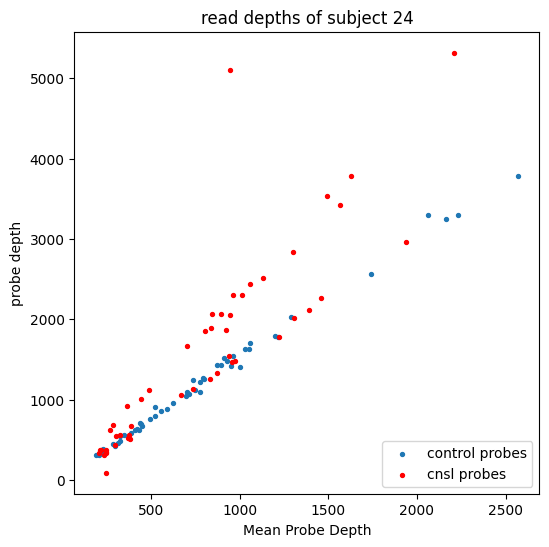

In [9]:

plt.figure(figsize=(6,6))
j = 24

plt.scatter(ctrl_mean_probe_depth, ctrl_df.iloc[j,:], s=8, label='control probes')
plt.scatter(cnsl_mean_probe_depth, cnsl_df.iloc[j,:], s=8, color='red', label='cnsl probes')

plt.xlabel('Mean Probe Depth')
plt.ylabel('probe depth')
plt.title('read depths of subject 24')
plt.legend()

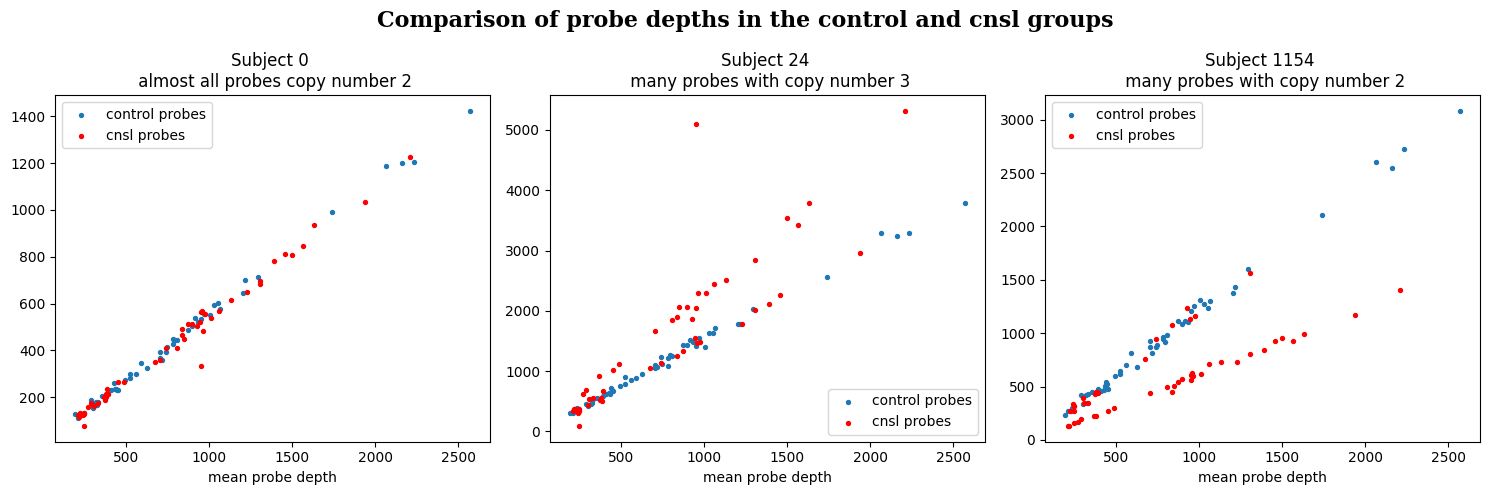

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 

# Plot scatterplots on each subplot
axs[0].scatter(ctrl_mean_probe_depth, ctrl_df.iloc[0,:], s=8, label='control probes')
axs[0].scatter(cnsl_mean_probe_depth, cnsl_df.iloc[0,:], s=8, color='red', label='cnsl probes')
axs[1].scatter(ctrl_mean_probe_depth, ctrl_df.iloc[24,:], s=8, label='control probes')
axs[1].scatter(cnsl_mean_probe_depth, cnsl_df.iloc[24,:], s=8, color='red', label='cnsl probes')
axs[2].scatter(ctrl_mean_probe_depth, ctrl_df.iloc[1154,:], s=8, label='control probes')
axs[2].scatter(cnsl_mean_probe_depth, cnsl_df.iloc[1154,:], s=8, color='red', label='cnsl probes')


# Set titles and labels
fig.suptitle('Comparison of probe depths in the control and cnsl groups', fontsize=16, fontweight='bold', fontfamily='serif', color='black')

axs[0].set_title('Subject 0 \n almost all probes copy number 2')
axs[0].set_xlabel('mean probe depth')
axs[0].legend()

axs[1].set_title('Subject 24 \n many probes with copy number 3')
axs[1].set_xlabel('mean probe depth')
axs[1].legend()

axs[2].set_title('Subject 1154 \n many probes with copy number 2')
axs[2].set_xlabel('mean probe depth')
axs[2].legend()

fig.tight_layout()

## Estimation of probe depths using the control group

In [11]:
# for each subject fit a line to depths in the control group
# use the line to estimate the expected depths in the test group

cnsl_expected_depth_df = cnsl_df.copy().astype(float)
param = [0]*10000
param_var = [0]*10000

def lin_fit(x, a):
    return a*x

for i in range(10000):
    param[i], param_var[i] = curve_fit(lin_fit, ctrl_mean_probe_depth, ctrl_df.iloc[i,:])
    cnsl_expected_depth_df.iloc[i,:] = param[i]*cnsl_mean_probe_depth
    

## Call variants on the test group

In [12]:
# Use multipliers do decide how much probe depths differ from expected depths and classify them

cnsl_multipliers = cnsl_df/cnsl_expected_depth_df

def call_variants(x):
    if x > 2:
        return 4
    elif x > 1.2:
        return 3
    elif x > .7:
        return 2
    elif x > .2:
        return 1
    else:
        return 0

cnsl_cnv = cnsl_multipliers.apply(lambda x:x.apply(call_variants), axis=1)

## Inspection of cnvs called

Check for 0 read depths in the cnsl group

In [13]:
cnsl_zero = (cnsl_df == 0).sum()
cnsl_zero = cnsl_zero[cnsl_zero > 0]
cnsl_zero

CNSL_probe_5    76
dtype: int64

Check the number of 2 cnv called on probes in the cnsl group  

In [14]:
(cnsl_cnv == 2).sum(axis=0).sort_values(ascending=True).head()

CNSL_probe_5     1978
CNSL_probe_46    3796
CNSL_probe_23    3882
CNSL_probe_32    9501
CNSL_probe_34    9523
dtype: int64

Check for 0 and 4 cnv

In [15]:
((cnsl_cnv == 0) | (cnsl_cnv==4)).sum(axis=0).sort_values(ascending=False).head()

CNSL_probe_5     3274
CNSL_probe_46     622
CNSL_probe_23     584
CNSL_probe_0        0
CNSL_probe_37       0
dtype: int64

Probes 5, 23 and 46 doesn not function correctly. They report too few 2 cnv and too many 0 and 4. Remove them from data

In [16]:
cnsl_cnv = cnsl_cnv.drop(['CNSL_probe_5','CNSL_probe_23','CNSL_probe_46'], axis=1)

## Find the indexes of the subjects that have a potential deletion or duplication

In [17]:
del_dup_ids = ((cnsl_cnv != 2).sum(axis=1) >3)
del_dup_ids = del_dup_ids[del_dup_ids].index
len(del_dup_ids)

477

In [18]:
del_dup_ids

Index([  24,   31,   35,   47,   58,   93,  140,  163,  234,  238,
       ...
       9756, 9827, 9844, 9850, 9883, 9887, 9903, 9926, 9968, 9970],
      dtype='int64', length=477)

In [19]:
cnsl_cnv.to_csv('cnsl_cnv_calls.csv')

In [20]:
cnsl_calls = cnsl_cnv.iloc[del_dup_ids,:]

In [21]:
(cnsl_calls == 3).sum(axis=1).value_counts()

0     141
20    118
30     58
7      57
8      54
9      12
21     11
1      10
31      7
29      4
22      2
2       1
19      1
6       1
Name: count, dtype: int64

In [22]:
(cnsl_calls == 1).sum(axis=1).value_counts()

0     325
8      56
7      56
20     26
30     14
Name: count, dtype: int64

Find the individuals with deletions or duplications for each cnv

In [23]:
brk_10_40_del = (cnsl_calls.iloc[:,8:40] == [2]+[1]*30+[2]).sum(axis=1) == 32
brk_10_40_del = brk_10_40_del.index[brk_10_40_del]

brk_10_40_dup = (cnsl_calls.iloc[:,8:40] == [2]+[3]*30+[2]).sum(axis=1) == 32
brk_10_40_dup = brk_10_40_dup.index[brk_10_40_dup]

brk_20_40_del = (cnsl_calls.iloc[:,18:40] == [2]+[1]*20+[2]).sum(axis=1) == 22
brk_20_40_del = brk_20_40_del.index[brk_20_40_del]

brk_20_40_dup = (cnsl_calls.iloc[:,18:40] == [2]+[3]*20+[2]).sum(axis=1) == 22
brk_20_40_dup = brk_20_40_dup.index[brk_20_40_dup]

brk_27_34_del = (cnsl_calls.iloc[:,24:34] == [2]+[1]*8+[2]).sum(axis=1) == 10
brk_27_34_del = brk_27_34_del.index[brk_27_34_del]

brk_27_34_dup = (cnsl_calls.iloc[:,24:34] == [2]+[3]*8+[2]).sum(axis=1) == 10
brk_27_34_dup = brk_27_34_dup.index[brk_27_34_dup]

brk_32_38_del = (cnsl_calls.iloc[:,29:38] == [2]+[1]*7+[2]).sum(axis=1) == 9
brk_32_38_del = brk_32_38_del.index[brk_32_38_del]

brk_32_38_dup = (cnsl_calls.iloc[:,29:38] == [2]+[3]*7+[2]).sum(axis=1) == 9
brk_32_38_dup = brk_32_38_dup.index[brk_32_38_dup]


In [24]:
len(brk_10_40_del)

14

In [25]:
# record the new results

del_10_40_df = pd.DataFrame({'ethnicity':ethnicities[brk_10_40_del], 'break_points': '10-40', 'type':'deletion'})
dup_10_40_df = pd.DataFrame({'ethnicity':ethnicities[brk_10_40_dup], 'break_points': '10-40', 'type':'duplication'})
del_20_40_df = pd.DataFrame({'ethnicity':ethnicities[brk_20_40_del], 'break_points': '20-40', 'type':'deletion'})
dup_20_40_df = pd.DataFrame({'ethnicity':ethnicities[brk_20_40_dup], 'break_points': '20-40', 'type':'duplication'})
del_27_34_df = pd.DataFrame({'ethnicity':ethnicities[brk_27_34_del], 'break_points': '27-34', 'type':'deletion'})
dup_27_34_df = pd.DataFrame({'ethnicity':ethnicities[brk_27_34_dup], 'break_points': '27-34', 'type':'duplication'})
del_32_38_df = pd.DataFrame({'ethnicity':ethnicities[brk_32_38_del], 'break_points': '32-38', 'type':'deletion'})
dup_32_38_df = pd.DataFrame({'ethnicity':ethnicities[brk_32_38_dup], 'break_points': '32-38', 'type':'duplication'})


In [26]:
# combine the results into one dataframe

results_df = pd.concat([del_10_40_df, dup_10_40_df, del_20_40_df, dup_20_40_df, del_27_34_df, dup_27_34_df, del_32_38_df, dup_32_38_df], axis=0)

In [27]:
results_df.loc[(results_df.type=='duplication') & (results_df.ethnicity=='B'),:]

,ethnicity,break_points,type
24,B,20-40,duplication
35,B,20-40,duplication
47,B,20-40,duplication
238,B,20-40,duplication
277,B,20-40,duplication
...,...,...,...
9710,B,20-40,duplication
9756,B,20-40,duplication
9883,B,20-40,duplication
9887,B,20-40,duplication


In [28]:
results_summary_df = results_df.groupby(['ethnicity','break_points','type']).agg(count=('ethnicity', 'count')).reset_index()

In [29]:
results_df.groupby(['ethnicity','break_points','type']).agg(total_count=('ethnicity', 'count')).reset_index()

,ethnicity,break_points,type,total_count
0,A,27-34,deletion,55
1,A,27-34,duplication,60
2,A,32-38,deletion,57
3,A,32-38,duplication,62
4,B,20-40,deletion,26
5,B,20-40,duplication,131
6,C,10-40,deletion,14
7,C,10-40,duplication,65


In [30]:
results_summary_df

,ethnicity,break_points,type,count
0,A,27-34,deletion,55
1,A,27-34,duplication,60
2,A,32-38,deletion,57
3,A,32-38,duplication,62
4,B,20-40,deletion,26
5,B,20-40,duplication,131
6,C,10-40,deletion,14
7,C,10-40,duplication,65


## Identify the subjects that have deletions or duplications that do not fit the hard coded break points

In [31]:
not_covered_ids = [id for id in del_dup_ids if id not in results_df.index]
(cnsl_calls.loc[not_covered_ids, :] == 3).sum(axis=0).sort_values(ascending=False)
cnsl_mean_probe_depth[cnsl_mean_probe_depth <300] 


CNSL_probe_3     298.29340
CNSL_probe_4     221.63560
CNSL_probe_5     244.81080
CNSL_probe_7     247.47220
CNSL_probe_11    245.18130
CNSL_probe_13    214.81305
CNSL_probe_18    206.46195
CNSL_probe_26    289.08190
CNSL_probe_36    269.58765
CNSL_probe_42    244.71020
CNSL_probe_47    237.64860
dtype: float64

In [32]:
cnsl_cnv.iloc[5259,25:43]
cnsl_cnv.iloc[12:,12:]#.loc[5259,:]#.iloc[:,8:40] == [2]+[3]*30+[2]).sum(axis=1)



,CNSL_probe_13,CNSL_probe_14,CNSL_probe_15,CNSL_probe_16,CNSL_probe_17,CNSL_probe_18,CNSL_probe_19,CNSL_probe_20,CNSL_probe_21,CNSL_probe_22,...,CNSL_probe_39,CNSL_probe_40,CNSL_probe_41,CNSL_probe_42,CNSL_probe_43,CNSL_probe_44,CNSL_probe_45,CNSL_probe_47,CNSL_probe_48,CNSL_probe_49
12,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
13,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
14,2,2,2,2,2,3,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
15,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
16,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
9996,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
9997,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
9998,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [33]:
(cnsl_calls.loc[not_covered_ids, :] == 1).sum(axis=1).sort_values(ascending=False)

2791    0
3513    0
5259    0
6169    0
6626    0
8424    0
9263    0
dtype: int64

The above two cells show that there are no deletions, only duplications. Also the number of duplications is 1 more or less than the number of probes between the breakpoint, suggesting that one probe had a off-reading. 

These 7 subjects has all duplications in the given areas except for 1 probe, or in one case the subject has an extra probe that is not within the breakpoints and reported a duplication. The probes that do not report duplications or report an extra duplication are all low coverage probes. I am adding these results to the exact fits, as the factors are missing the boundaries I set by a narrow margin and nationalities also align with the other results.

In [34]:
results_2_df = pd.DataFrame({'ethnicity':ethnicities[not_covered_ids], 'break_points':(cnsl_calls.loc[not_covered_ids,:]==3).sum(axis=1), 'type':'duplication'})
results_2_df['break_points'] = results_2_df.break_points.astype('str')
results_2_df.loc[results_2_df.break_points=='29','break_points']='10-40'
results_2_df.loc[results_2_df.break_points=='19','break_points']='20-40'
results_2_df.loc[results_2_df.break_points=='6','break_points']='32-38'
results_2_df.loc[results_2_df.break_points=='9','break_points']='27-34'

In [35]:
results_2_df

,ethnicity,break_points,type
2791,C,10-40,duplication
3513,C,10-40,duplication
5259,C,10-40,duplication
6169,B,20-40,duplication
6626,C,10-40,duplication
8424,A,32-38,duplication
9263,A,27-34,duplication


Add the new results to the previous ones

In [36]:
results = pd.concat([results_df, results_2_df], axis=0)

In [37]:
results

,ethnicity,break_points,type
1154,C,10-40,deletion
1874,C,10-40,deletion
1883,C,10-40,deletion
2998,C,10-40,deletion
3004,C,10-40,deletion
...,...,...,...
5259,C,10-40,duplication
6169,B,20-40,duplication
6626,C,10-40,duplication
8424,A,32-38,duplication


In [38]:
results_summary = results.groupby(['ethnicity','break_points','type']).agg(total=('ethnicity', 'count')).reset_index()
results_summary

,ethnicity,break_points,type,total
0,A,27-34,deletion,55
1,A,27-34,duplication,61
2,A,32-38,deletion,57
3,A,32-38,duplication,63
4,B,20-40,deletion,26
5,B,20-40,duplication,132
6,C,10-40,deletion,14
7,C,10-40,duplication,69


Check that all of the 477 subjects that had a duplication or deletion are in the results table

In [39]:
results_summary.total.sum()

477

In [40]:
ctrl_df_normalized = ctrl_df.apply(lambda x:x/ctrl_mean_sample_depth[x.index], axis=0)
(ctrl_df_normalized.max()/ctrl_df_normalized.min()).sort_values(ascending=False).head(10)

non_CNSL_probe_23    2.119624
non_CNSL_probe_5     2.086629
non_CNSL_probe_2     2.058856
non_CNSL_probe_22    1.988645
non_CNSL_probe_41    1.793198
non_CNSL_probe_11    1.792879
non_CNSL_probe_47    1.791824
non_CNSL_probe_12    1.731398
non_CNSL_probe_7     1.707696
non_CNSL_probe_26    1.685221
dtype: float64

In [41]:
ctrl_mean_probe_depth[(ctrl_df_normalized.max()/ctrl_df_normalized.min()).sort_values(ascending=False).head(10).index]

non_CNSL_probe_23    188.2184
non_CNSL_probe_5     225.3541
non_CNSL_probe_2     230.4160
non_CNSL_probe_22    209.7056
non_CNSL_probe_41    287.1064
non_CNSL_probe_11    295.9595
non_CNSL_probe_47    316.7660
non_CNSL_probe_12    325.4926
non_CNSL_probe_7     350.6118
non_CNSL_probe_26    327.5566
dtype: float64

In [42]:
ctrl_mean_probe_depth.sort_values()

non_CNSL_probe_23     188.2184
non_CNSL_probe_22     209.7056
non_CNSL_probe_5      225.3541
non_CNSL_probe_2      230.4160
non_CNSL_probe_41     287.1064
non_CNSL_probe_11     295.9595
non_CNSL_probe_47     316.7660
non_CNSL_probe_12     325.4926
non_CNSL_probe_26     327.5566
non_CNSL_probe_7      350.6118
non_CNSL_probe_0      389.5995
non_CNSL_probe_14     409.5431
non_CNSL_probe_44     424.6951
non_CNSL_probe_46     432.3009
non_CNSL_probe_30     438.5051
non_CNSL_probe_42     445.7685
non_CNSL_probe_20     449.2711
non_CNSL_probe_37     493.8287
non_CNSL_probe_24     523.0664
non_CNSL_probe_38     523.3847
non_CNSL_probe_15     556.7663
non_CNSL_probe_19     589.3922
non_CNSL_probe_32     625.4293
non_CNSL_probe_25     699.6952
non_CNSL_probe_18     704.5855
non_CNSL_probe_8      717.4983
non_CNSL_probe_36     736.7536
non_CNSL_probe_49     747.0667
non_CNSL_probe_1      779.0409
non_CNSL_probe_10     779.5495
non_CNSL_probe_29     794.4405
non_CNSL_probe_16     802.0490
non_CNSL

## Summarize and plot results

In [43]:
results_summary['ethnicity and break_point'] = results_summary['ethnicity'] + ' at ' + results_summary['break_points']
results_summary['ethnicity population'] = results_summary.ethnicity.apply(lambda eth:ethnicity_counts[eth])
results_summary['del_dup_frequency'] = results_summary['total']/results_summary['ethnicity population']

In [44]:
results_summary

,ethnicity,break_points,type,total,ethnicity and break_point,ethnicity population,del_dup_frequency
0,A,27-34,deletion,55,A at 27-34,4988,0.011026
1,A,27-34,duplication,61,A at 27-34,4988,0.012229
2,A,32-38,deletion,57,A at 32-38,4988,0.011427
3,A,32-38,duplication,63,A at 32-38,4988,0.012630
4,B,20-40,deletion,26,B at 20-40,2543,0.010224
5,B,20-40,duplication,132,B at 20-40,2543,0.051907
6,C,10-40,deletion,14,C at 10-40,2469,0.005670
7,C,10-40,duplication,69,C at 10-40,2469,0.027947


Text(0, 0.5, 'Frequency')

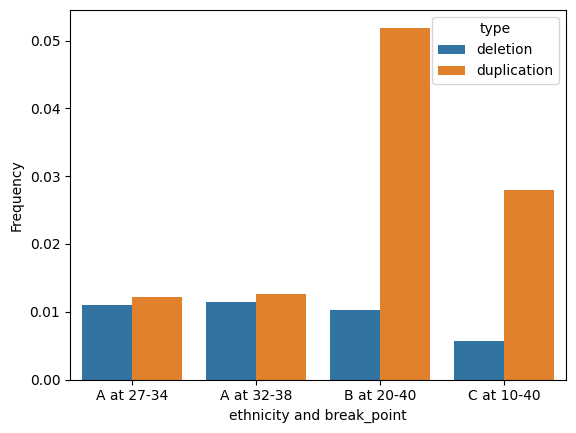

In [45]:
sns.barplot(data=results_summary, x='ethnicity and break_point', y='del_dup_frequency', hue='type')

plt.ylabel('Frequency')

In [46]:
results_summary.iloc[:,[0,1,2,3,6]].rename({'del_dup_frequency':'frequency'}, axis=1)

,ethnicity,break_points,type,total,frequency
0,A,27-34,deletion,55,0.011026
1,A,27-34,duplication,61,0.012229
2,A,32-38,deletion,57,0.011427
3,A,32-38,duplication,63,0.012630
4,B,20-40,deletion,26,0.010224
5,B,20-40,duplication,132,0.051907
6,C,10-40,deletion,14,0.005670
7,C,10-40,duplication,69,0.027947
